# Using agnostic explainers

In this notebook, we'll create a simple IT expression and use popular model-agnostic explainer methods to obtain feature importances for the final model.

The explainers we are going to use are SHAP, LIME, and PDP.

To contrast with our model-specific explainer based on the Partial Effects, the same dataset used in the regression notebook will be used.

Many explainers are still in development and can change in future versions. The versions used in this notebook are commented below.

In [1]:
import numpy  as np
import pandas as pd

import shap #0.34.0
import sage #https://github.com/iancovert/sage

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display

import matplotlib.pyplot as plt

from itea.regression import ITEA_regressor
from itea.inspection import *

from lime import lime_tabular #0.1.1.37

from sklearn.inspection import plot_partial_dependence # 0.24.2

from interpret.blackbox import MorrisSensitivity #0.2.5

import warnings
warnings.filterwarnings(action='ignore', module=r'itea')

Performing the evolution and retrieving the best solution.

In [2]:
housing_data = datasets.fetch_california_housing() 
X, y   = housing_data['data'], housing_data['target']
labels = housing_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'sin'      : np.sin,
    'cos'      : np.cos,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'sin'      : np.cos,
    'cos'      : lambda x: -np.sin(x),
    'exp'      : np.exp,
}

reg = ITEA_regressor(
    gens         = 75,
    popsize      = 75,
    max_terms    = 5,
    expolim      = (0, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 42,
    simplify_method = 'simplify_by_var'
).fit(X_train, y_train)

final_itexpr = reg.bestsol_

print(final_itexpr)

gen | smallest fitness | mean fitness | highest fitness | remaining time (s)
----------------------------------------------------------------------------
  0 |         0.879653 |     1.109206 |        1.153697 | 1min12seg   
 10 |         0.815819 |     0.852481 |        1.133898 | 4min33seg   
 20 |         0.785301 |     0.795977 |        0.872630 | 3min41seg   
 30 |         0.774451 |     0.780758 |        0.826534 | 3min24seg   
 40 |         0.769231 |     0.776211 |        0.800035 | 2min35seg   
 50 |         0.769231 |     0.774910 |        0.861931 | 2min1seg    
 60 |         0.763084 |     0.780482 |        0.995355 | 1min9seg    
 70 |         0.748003 |     0.773957 |        0.860793 | 0min20seg   
-15.231*log(MedInc * Population * AveOccup * Latitude^2) + 1.323*log(MedInc^2 * AveBedrms * Longitude^2) + 37.981*log(MedInc * Population * AveOccup * Latitude * Longitude^2) + -0.399*log(MedInc^2 * AveRooms^2 * AveBedrms * AveOccup * Latitude^2 * Longitude^2) + -11.439*log(Med

## Explaining with PDP

Since ``ITExpr_regressor`` is a subclass of scikit-learn base classes ``RegressorMixin`` and ``BaseEstimator``, we can use the Partial Dependency Plot (PDP) and Individual Conditional Expectation (ICE), that works with any scikit estimator.

The ``plot_partial_dependence`` function from scikit-learn package allows explaining any scikit machine learning model. It can be used to explain an ITEA model.

The PDP is discussed and the ICE is proposed in paper _A. Goldstein, A. Kapelner, J. Bleich, and E. Pitkin, Peeking Inside the Black Box: Visualizing Statistical Learning With Plots of Individual Conditional Expectation, Journal of Computational and Graphical Statistics, 24(1): 44-65, Springer, 2015._

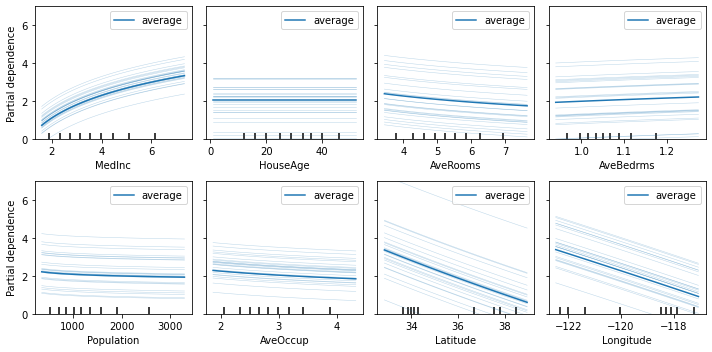

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

plot_partial_dependence(
    estimator = final_itexpr,
    X = X_train,
    features = range(8),
    n_jobs = 3,
    kind = 'both',
    subsample = 25,
    grid_resolution = 100,
    ax = axs,
    method = 'auto'
)

for ax, label in zip(fig.axes, labels):
    ax.set_xlabel(label)
    ax.set_ylim([0, 7])

plt.tight_layout()
plt.show()

The PDP function lets you specify two features to create a more interesting visualization of the relationship between them. Let us create this plot using the top 2 most important features.

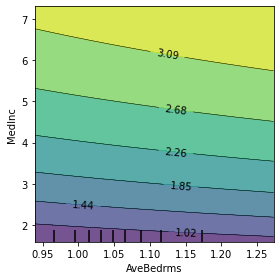

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

top1, top2 = (-final_itexpr.feature_importances_).argsort()[0, :2]

plot_partial_dependence(
    estimator = final_itexpr,
    X = X,
    features = [(top1, top2)],
    n_jobs = 3,
    subsample = 10,
    grid_resolution = 50,
    ax = ax,
    method = 'auto'
)

plt.xlabel(labels[top1])
plt.ylabel(labels[top2])

plt.tight_layout()
plt.show()

## Explaining with SHAP

The SHapley Additive exPlanations (SHAP) was proposed in _Lundberg, Scott & Lee, Su-In. (2017). A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems. Curran Associates, Inc.._ 

SHAP package implements several visualization plots, including the bar plot.

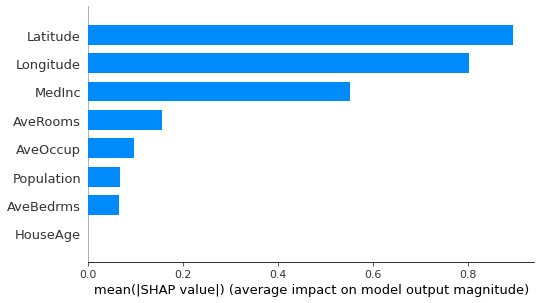

In [5]:
shap_explainer = shap.KernelExplainer(
    final_itexpr.predict,
    shap.sample(pd.DataFrame(X_train, columns=labels), 100)
)

shap.summary_plot(
    shap_explainer.shap_values(
        X_test[:100, :], l1_reg='num_features(10)'),
    shap.sample(
        pd.DataFrame(X_test[:100, :], columns=labels), 100),
    plot_type="bar"
)

We can obtain explanations for a single instance with the ``force_plot``:

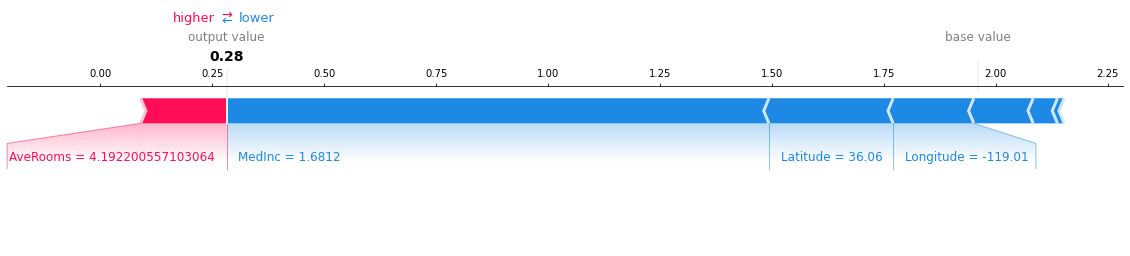

In [6]:
shap.force_plot(
    shap_explainer.expected_value,
    shap_explainer.shap_values(
        X_test[0,:], l1_reg='num_features(10)'),
    pd.DataFrame(X_test, columns=labels).iloc[0,:],
    matplotlib=True
)

SHAP also implements a dependence plot:

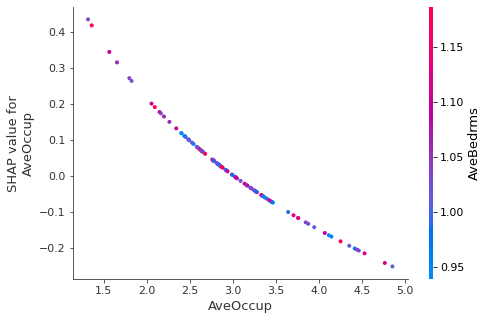

In [7]:
shap.dependence_plot(
    "AveOccup",
    shap_explainer.shap_values(
        X_test[:100, :], l1_reg='num_features(10)'),
    pd.DataFrame(X_test[:100, :], columns=labels)
)

## Explaining with LIME

Local Interpretable Model-agnostic Explainer (LIME) was proposed in _Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should I trust you?: Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2016._

In [8]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, mode="regression", feature_names= labels)

# LIME only supports local explanations.
explanation = explainer.explain_instance(
    X_test[0], final_itexpr.predict, num_features=len(labels))

explanation.show_in_notebook()

## Morris Sensitivity

InterpretML is an interpretability dashboard with the implementation of many model agnostic explainers created by Microsoft, reported in the paper  _"InterpretML: A Unified Framework for Machine Learning Interpretability" (H. Nori, S. Jenkins, P. Koch, and R. Caruana 2019)_.

While they implement the SHAP, LIME, and PDP, those were already used in the previous cells in this notebook (although they have interactive plots, which can be cool for deep interpretability analyses). One new model agnostic explainer that they provide and can be used with ITEA is the Morris Sensitivity explainer.

This method changes one step at a time (OAT) to evaluate the sensitivity of the model regarding each variable independently (meaning that it [cannot differentiate interactions with non-linearities]([https://interpret.ml/docs/msa.html)), but have a fast computation of the feature importances in a global perspective.

The plot function of the interpretML package uses plotly, making difficult to save and report the plot in this notebook. Thankfully, they have a method to access the data used in the plots. In te cell bellow we'll extract the importances and recreate the plot using matplotlib.

{'names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'scores': masked_array(data=[5.1898983877305955, 0.0, 3.4694871758931534,
                   3.2587057616663047, 0.7891995123475715,
                   1.9386656396830597, 4.06142399820332,
                   4.4510886539917704],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20), 'convergence_index': 0.04545696662135615}


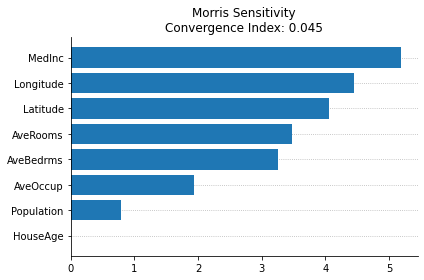

In [9]:
msa = MorrisSensitivity(
    predict_fn=final_itexpr.predict, data=X_test, feature_names=final_itexpr.labels.tolist(),
    feature_types=['continuous']*8
)
msa_global = msa.explain_global()

data = msa_global.data()

print(data)

fig, ax = plt.subplots()

features    = np.array(data['names'])
y_pos       = np.arange(len(data['names']))
importances = np.array(data['scores'])
order       = np.argsort(importances)[::-1]

ax.barh(y_pos, importances[order], align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(features[order])
ax.invert_yaxis()

ax.set_title(
    f'Morris Sensitivity\nConvergence Index: {np.round(data["convergence_index"], 3)}')

ax.grid(axis='y', zorder=-1, ls=':')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## Explaining with sage



In [10]:
# Setup and calculate
imputer   = sage.MarginalImputer(final_itexpr, X_test[:512])
estimator = sage.PermutationEstimator(imputer, 'mse')

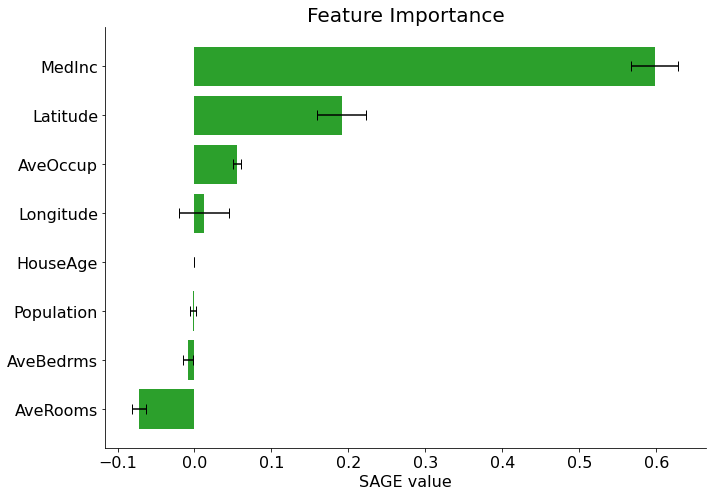

In [11]:
sage_values = estimator(X_test, y_test)
sage_values.plot(final_itexpr.labels)

Calculating model sensitivity (Shapley Effects, not SAGE)


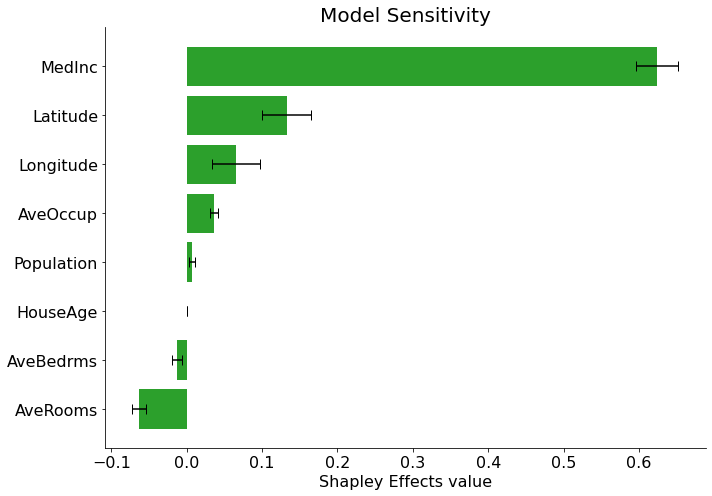

In [12]:
sensitivity = estimator(X_test)
sensitivity.plot(final_itexpr.labels, title='Model Sensitivity')

## Generating explanations with ``ITEA_summarizer``

The ``ITEA_summarizer`` provides a method to automatically generate multiple interpretability plots given an ``ITEA`` instance.

To compare the explanations from different explainers with the explanations through Partial Effects, we'll use the ``autoreport()`` method to create a pdf file.

This file will have several explanations of the given ``itexpr``, and the file generated from the cell below can be downloaded [by clicking here](https://galdeia.github.io/itea-python/_static/files/Report.pdf).

In [13]:
summarizer = (
    ITEA_summarizer(itea=reg)
    .fit(X_train, y_train)
    .autoreport(save_path='.')
)